# Introdução

*Churn* pode ser entendido como o ato, feito por parte do cliente, de cancelar um determinado serviço. Também conhecido como atrito, esse é um grande problema enfrentado por empresas que dependam da fidelidade, como as que oferecem *Software as a Service* ou serviços financeiros como Cartões de Crédito.

A base de dados apresentada aqui trata justamente do problema do *Churn* em uma empresa de cartão de crédito. O interesse aqui é tentar entender os principais fatores por trás da decisão de cancelar o cartão, e posteriormente tentar prever quais clientes entrarão em atríto. Sabendo disso é possível criar políticas focadas nos clientes com potencial de atrito, aumentando a taxa de fidelidade com a empresa.

# Exploração dos Dados

Antes de tudo vamos importar os pacotes necessários para a análise.

In [1]:
import pandas as pd
import altair as alt
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
alt.data_transformers.enable("json")
alt.renderers.enable("mimetype")

RendererRegistry.enable('mimetype')

Como iremos treinar alguns modelos posteriormente, é importante já dividirmos o conjunto de dados em um de treinamento e em outro de teste e focarmos nossa análise somente no conjunto de treinamento.

In [3]:
cc_churn = pd.read_csv("../data/raw/credit_card_churn.csv").iloc[:, :-2]

cc_churn_tr, cc_churn_tt = train_test_split(cc_churn, test_size=0.2, random_state=42)

In [4]:
cc_churn_tr

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
9066,713071383,Existing Customer,54,F,1,Unknown,Single,Unknown,Blue,36,...,3,3,3723.0,1728,1995.0,0.595,8554,99,0.678,0.464
5814,714246333,Attrited Customer,58,F,4,High School,Married,Unknown,Blue,48,...,4,3,5396.0,1803,3593.0,0.493,2107,39,0.393,0.334
792,718206783,Existing Customer,45,F,4,Unknown,Single,Less than $40K,Gold,36,...,1,3,15987.0,1648,14339.0,0.732,1436,36,1.250,0.103
1791,721096983,Existing Customer,34,F,2,Graduate,Single,Less than $40K,Blue,36,...,3,4,3625.0,2517,1108.0,1.158,2616,46,1.300,0.694
5011,720028683,Existing Customer,49,F,2,High School,Married,$40K - $60K,Blue,39,...,3,4,2720.0,1926,794.0,0.602,3806,61,0.794,0.708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,769053033,Attrited Customer,44,F,1,Graduate,Single,$40K - $60K,Blue,38,...,2,5,4142.0,2517,1625.0,0.809,2104,44,0.833,0.608
5191,714406158,Attrited Customer,53,F,3,High School,Divorced,Unknown,Blue,36,...,3,6,7939.0,0,7939.0,0.551,2269,42,0.312,0.000
5390,714140133,Existing Customer,42,F,4,Graduate,Unknown,Less than $40K,Blue,32,...,1,2,2314.0,1547,767.0,0.804,4678,74,1.000,0.669
860,720244983,Existing Customer,40,M,3,Unknown,Single,$40K - $60K,Blue,28,...,1,1,3563.0,1707,1856.0,0.506,1482,42,0.312,0.479


In [5]:
cc_churn_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8101 entries, 9066 to 7270
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 8101 non-null   int64  
 1   Attrition_Flag            8101 non-null   object 
 2   Customer_Age              8101 non-null   int64  
 3   Gender                    8101 non-null   object 
 4   Dependent_count           8101 non-null   int64  
 5   Education_Level           8101 non-null   object 
 6   Marital_Status            8101 non-null   object 
 7   Income_Category           8101 non-null   object 
 8   Card_Category             8101 non-null   object 
 9   Months_on_book            8101 non-null   int64  
 10  Total_Relationship_Count  8101 non-null   int64  
 11  Months_Inactive_12_mon    8101 non-null   int64  
 12  Contacts_Count_12_mon     8101 non-null   int64  
 13  Credit_Limit              8101 non-null   float64
 14  Total

Os dados não parecem sofrer com *missings*.

In [6]:
len(cc_churn_tr["CLIENTNUM"].unique())

8101

A variável `CLIENTNUM` é um identificador único de cada cliente. Para os propósitos daqui, não será uma variável útil. Irei excluí-la.

In [7]:
cc_churn_tr = cc_churn_tr.drop("CLIENTNUM", axis = 1)

A variável que vamos tentar prever é `Attrition_Flag`. Percebe-se que a taxa de atrito dessa empresa, dada pela nossa categoria positiva `Attrited Customer`, é de cerca de 16%, o que mostra também que é uma variável desbalanceada em favor da categoria negativa `Existing Customer`. Isso significa também que a métrica de *accuracy* não será muito útil aqui.

In [8]:
cc_churn_tr["Attrition_Flag"].value_counts(normalize=True)

Existing Customer    0.839526
Attrited Customer    0.160474
Name: Attrition_Flag, dtype: float64

## Visualizações

Vamos criar algumas funções para facilitar a visualização dos dados.

In [9]:
def plot_cont_var(var, width=200):
    dens = alt.Chart(cc_churn_tr).transform_density(
        var,
        groupby=["Attrition_Flag"],
        as_=[var, "Density"]
    ).mark_area(opacity=0.3).encode(
        x=f"{var}:Q",
        y="Density:Q",
        color="Attrition_Flag:N"
    )
    
    rule = alt.Chart(cc_churn_tr).mark_rule().encode(
        x=f"mean({var})",
        color="Attrition_Flag:N"
    )
    return (dens + rule).properties(width=width)

def plot_disc_var(var, width=20):
    df_norm = cc_churn_tr.groupby(
        [var, "Attrition_Flag"]
    ).size().div(
        cc_churn_tr.groupby(
            ["Attrition_Flag"]
        ).size()).reset_index().rename(
        columns={0: "Percentage"}
    )
    
    bar_norm = alt.Chart(df_norm).mark_bar().encode(
        x=alt.X("Attrition_Flag:N", axis=alt.Axis(title="")),
        y=alt.Y("Percentage:Q", axis=alt.Axis(format='.0%')),
        color=alt.Color("Attrition_Flag:N"),
        column=var
    )

    return bar_norm.properties(width=width)

def plot_corr(df):
    df_corr = df.corr()
    mask = np.triu(np.ones_like(df_corr, dtype=bool))
    tri_df_corr = df_corr.mask(mask)
    
    corr = tri_df_corr.reset_index().melt(id_vars="index", value_vars=tri_df_corr.columns).dropna(subset="value").sort_values("value", ascending=False)
    corr["comb"] = corr["index"].str.cat(corr["variable"], sep="-")
    
    corr_bar_plot = alt.Chart(corr).mark_bar().encode(
        x="value:Q",
        y=alt.Y("comb:N", sort="-x"),
        color=alt.condition(
            alt.datum.value > 0,
            alt.value("steelblue"),
            alt.value("orange")
        )
    )
    
    vline_corr = alt.Chart().mark_rule(color="red").encode(
        x=alt.datum(0.8)
    )
    
    return corr_bar_plot + vline_corr

In [10]:
cc_churn_tr.describe()

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
count,8101.000000,8101.000000,8101.000000,8101.000000,8101.000000,8101.000000,8101.000000,8101.000000,8101.000000,8101.000000,8101.000000,8101.000000,8101.000000,8101.000000
mean,46.306382,2.334773,35.923590,3.813233,2.346871,2.450315,8636.548068,1160.382792,7476.165276,0.760809,4402.988150,64.907789,0.712176,0.273187
std,8.022527,1.289564,8.024359,1.551838,1.014177,1.100687,9086.419557,815.504293,9080.279910,0.216668,3401.709545,23.556379,0.239321,0.274595
min,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,326.000000,1341.000000,0.632000,2160.000000,45.000000,0.583000,0.022000
50%,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1273.000000,3495.000000,0.738000,3897.000000,67.000000,0.702000,0.174000
75%,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11128.000000,1782.000000,9942.000000,0.859000,4739.000000,81.000000,0.818000,0.497000
max,70.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,2.675000,18484.000000,139.000000,3.714000,0.999000


In [11]:
cc_churn_tr.describe(include="object")

,Attrition_Flag,Gender,Education_Level,Marital_Status,Income_Category,Card_Category
count,8101,8101,8101,8101,8101,8101
unique,2,2,7,4,6,4
top,Existing Customer,F,Graduate,Married,Less than $40K,Blue
freq,6801,4279,2528,3767,2812,7557


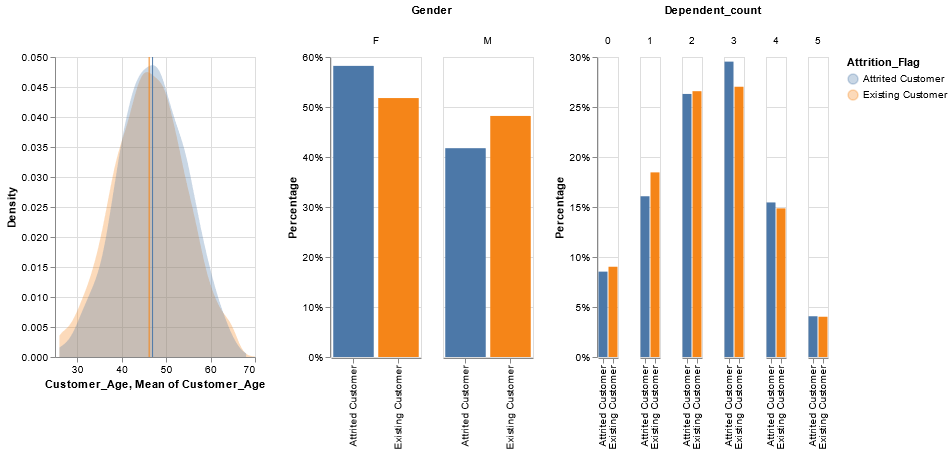

In [12]:
plot_cont_var("Customer_Age") | plot_disc_var("Gender", 90) | plot_disc_var("Dependent_count")

- Idade do Cliente (`Customer_Age`): A idade de clientes em atrito é um pouco maior, em média, apesar da distribuição entre os grupos ser bastante semelhante;
- Gênero (`Gender`): A proporção de clientes em atrito é maior entre o sexo feminino;
- Número de Dependentes (`Dependent_Count`): Proporcionalmente os clientes em atrito tendem a ter três ou mais dependentes quando comparado aos clientes existentes.

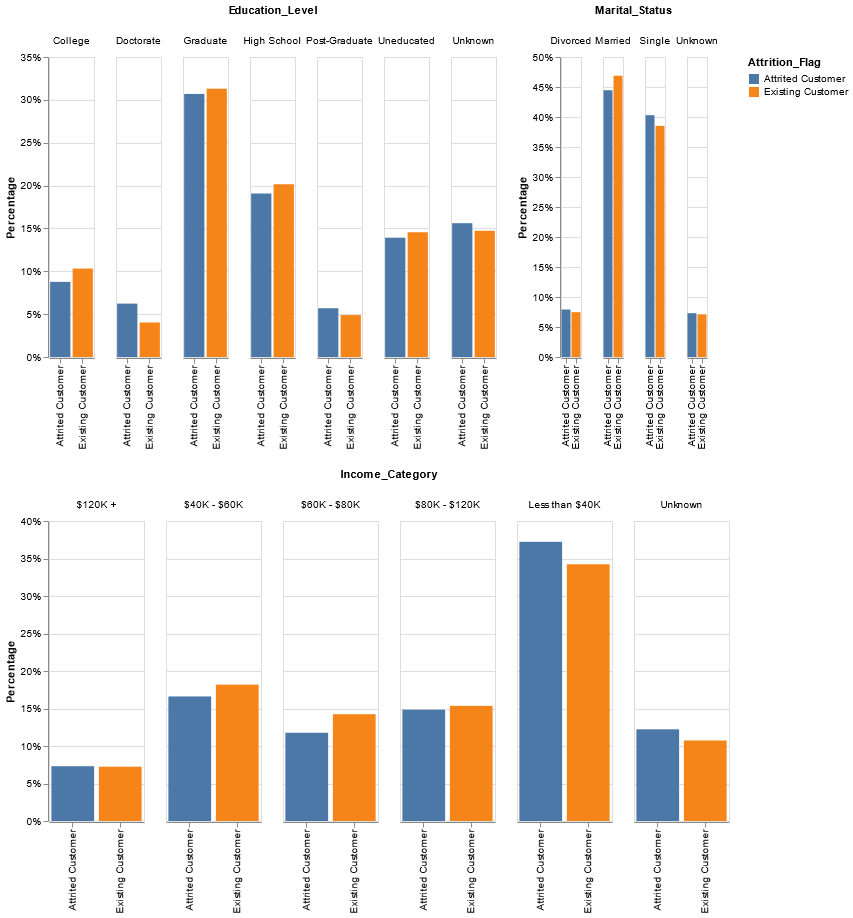

In [13]:
(plot_disc_var("Education_Level", 45) | plot_disc_var("Marital_Status")) & plot_disc_var("Income_Category", 95)

- Nível de Educação (`Education_Level`): A maior parte dos clientes, seja em atrito ou não, tem nível `Graduate` (Equivalente no Brasil à Pós-Graduação). Na comparação entre os grupos, clientes em atrito são maiores entre os níveis de `Doctorate`, `Post-Graduate` e `Unknown`. Fora do Brasil, `Graduate`, `Doctorate` e `Post-Graduate` são todos estudos feitos após a `Undergraduation` (Ou Graduação aqui no Brasil). Após análise vamos agregar essas três categorias;
- Estado Cívil (`Marital Status`): A proporção de clientes em atrito é maior nas categorias de `Divorced` e `Single`;
- Nível de Renda (`Income_Category`): Os clientes em atrito são maiores proporcionalmente nas categorias `Less than $40K$` e `Unknown`.

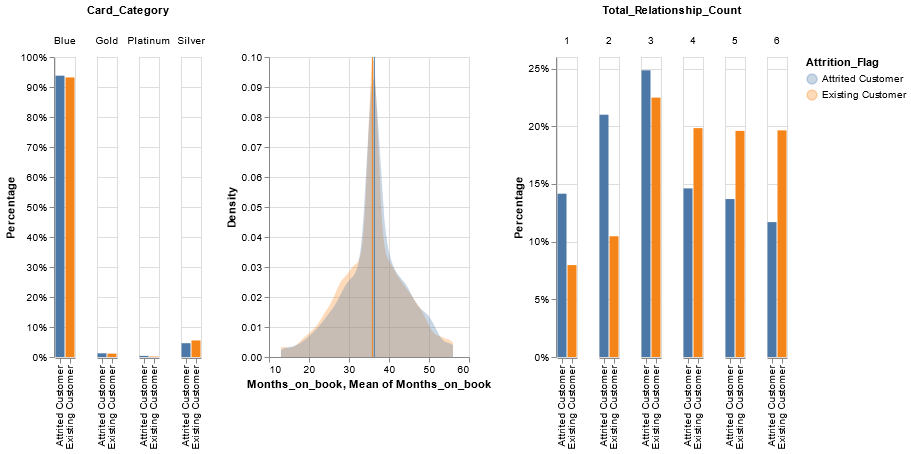

In [14]:
plot_disc_var("Card_Category") | plot_cont_var("Months_on_book") | plot_disc_var("Total_Relationship_Count")

- Categoria do Cartão (`Card_Category`): Mais de 90% dos clientes, em ambos os status, tem cartão de categoria `Blue`, normalmente reservado a cartões de crédito de "entrada";
- Periodo de relacionamento com o banco (`Months_on_book`): A distribuição de ambos os grupos é bem concentrado ao redor da média de mais ou menos 35 meses, com pouca diferença da média entre os grupos;
- Número de produtos do banco na mão da cliente (`Total_Relationship_Count`): Clientes em atrito tendem a ter menos produtos que o banco, com quantidade concentrada em <= 3 produtos.

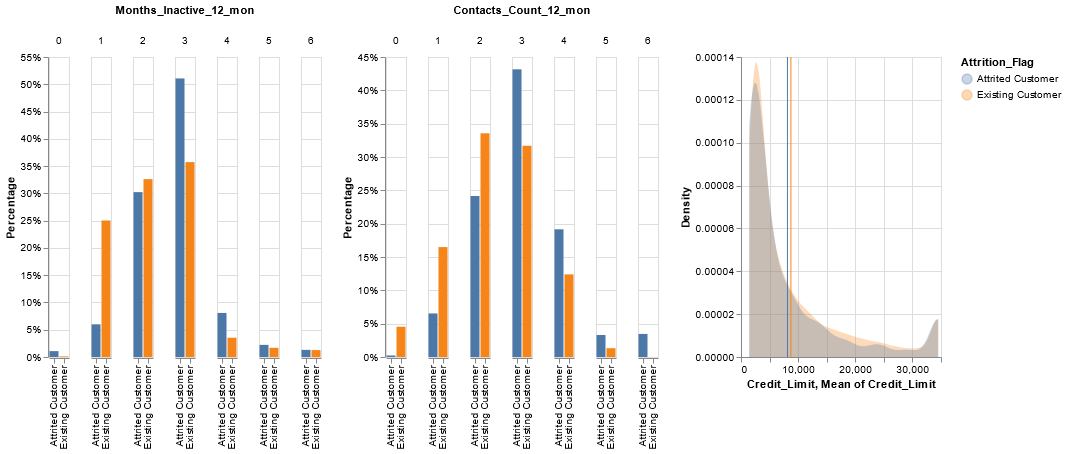

In [15]:
plot_disc_var("Months_Inactive_12_mon", 20) | plot_disc_var("Contacts_Count_12_mon") | plot_cont_var("Credit_Limit")

- Meses Inativos nos Últimos 12 Meses (`Months_Inactive_12_mon`) e Número de Contatos nos Últimos 12 Meses (`Contacts_Count_12_mon`): Clientes em atrito tendem a ter mais meses em inatividade nos ultimos 12 meses e mais contatos (a partir de 3);
- Limite de Crédito (`Credit_Limit`): Distriuições praticamente semelhantes, com a média um pouco maior para clientes existentes.

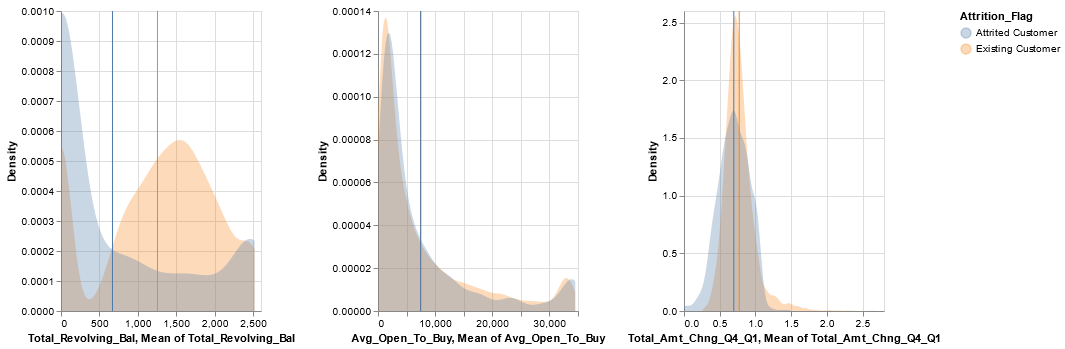

In [16]:
plot_cont_var("Total_Revolving_Bal") | plot_cont_var("Avg_Open_To_Buy") | plot_cont_var("Total_Amt_Chng_Q4_Q1")

- Saldo Total do Rotativo (`Total_Revolving_Bal`): Tende a ser menor entre os clientes em atrito. A distribuição entre os dois grupos difere bastante, inclusive. Entre os clientes em atrito o saldo se concentra muito ao redor do 0;
- Limite Disponível (`Avg_Open_To_Buy`): As médias são praticamente as mesmas, tal como as distribuições. Cabe notar também a semelhança das distribuições com `Credit_Limit`. Parece haver uma alta correlação;
- Mudança no Valor Total de Transações entre o 4º e 1º Semestre (`Total_Amt_Chng_Q4_Q1`): A distribuição do grupo de clientes em atrito tende a ser mais "gorda" à esquerda enquanto que no grupo de clientes existentes a distribuição é mais "gorda" à direita. Ou seja, é mais provável encontrar clientes em atrito que diminuiram seus gastos (quando `Total_Amt_Chng_Q4_Q1` < 1), enquanto que clientes existentes tendem a ter aumentado seus gastos (quando `Total_Amt_Chng_Q4_Q1` > 1).

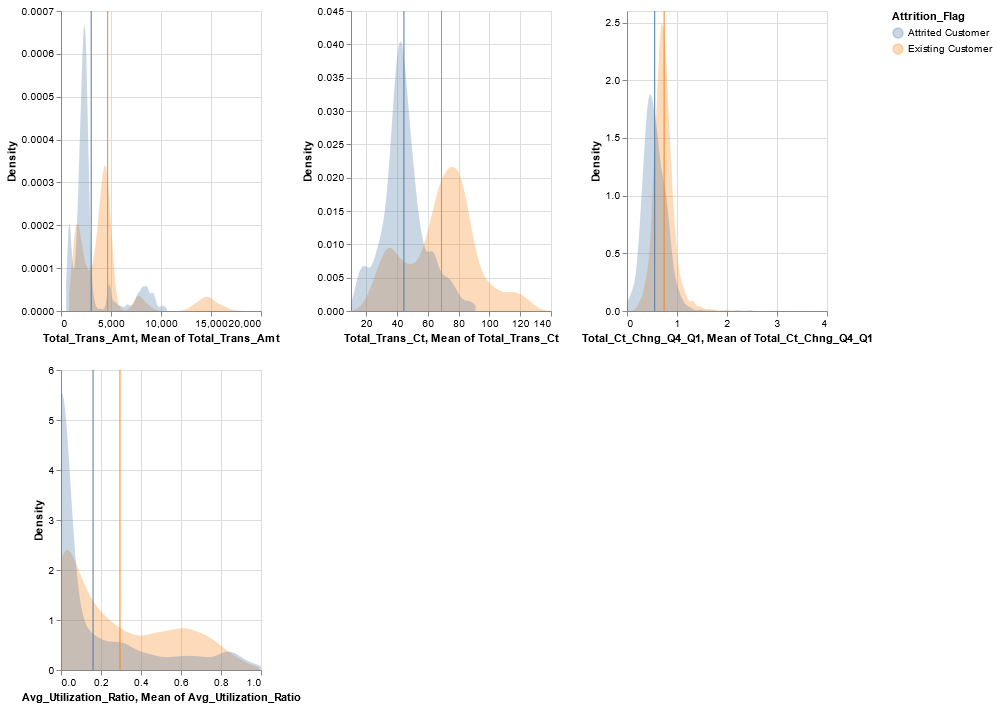

In [17]:
(plot_cont_var("Total_Trans_Amt") | plot_cont_var("Total_Trans_Ct") | plot_cont_var("Total_Ct_Chng_Q4_Q1")) & plot_cont_var("Avg_Utilization_Ratio")

- Valor Total de Transações nos Últimos 12 Meses (`Total_Trans_Amt`): Os clientes em atrito gastaram, em média, menos do que os clientes em atrito nos últimos 12 meses;
- Número Total de Transações nos Últimos 12 Meses (`Total_Trans_Ct`): Clientes em atrito fizeram menos transações nos últimos 12 meses do que os clientes existentes;
- Mudança no Número de Transações entre o 4º e 1º Trimestre (`Total_Ct_Chng_Q4_Q1`): Clientes em atrito tenderam a diminuir o número de transações durante os trimestres;
- Média da Razão de Utilização (`Avg_Utilization_Ratio`): A Razão de Utilização é da pela soma dos gastos no cartão dividido pelo limite. O grupo de clientes em atrito tende a gastar menos, na média, como proporção do seu limite. 

## Correlações

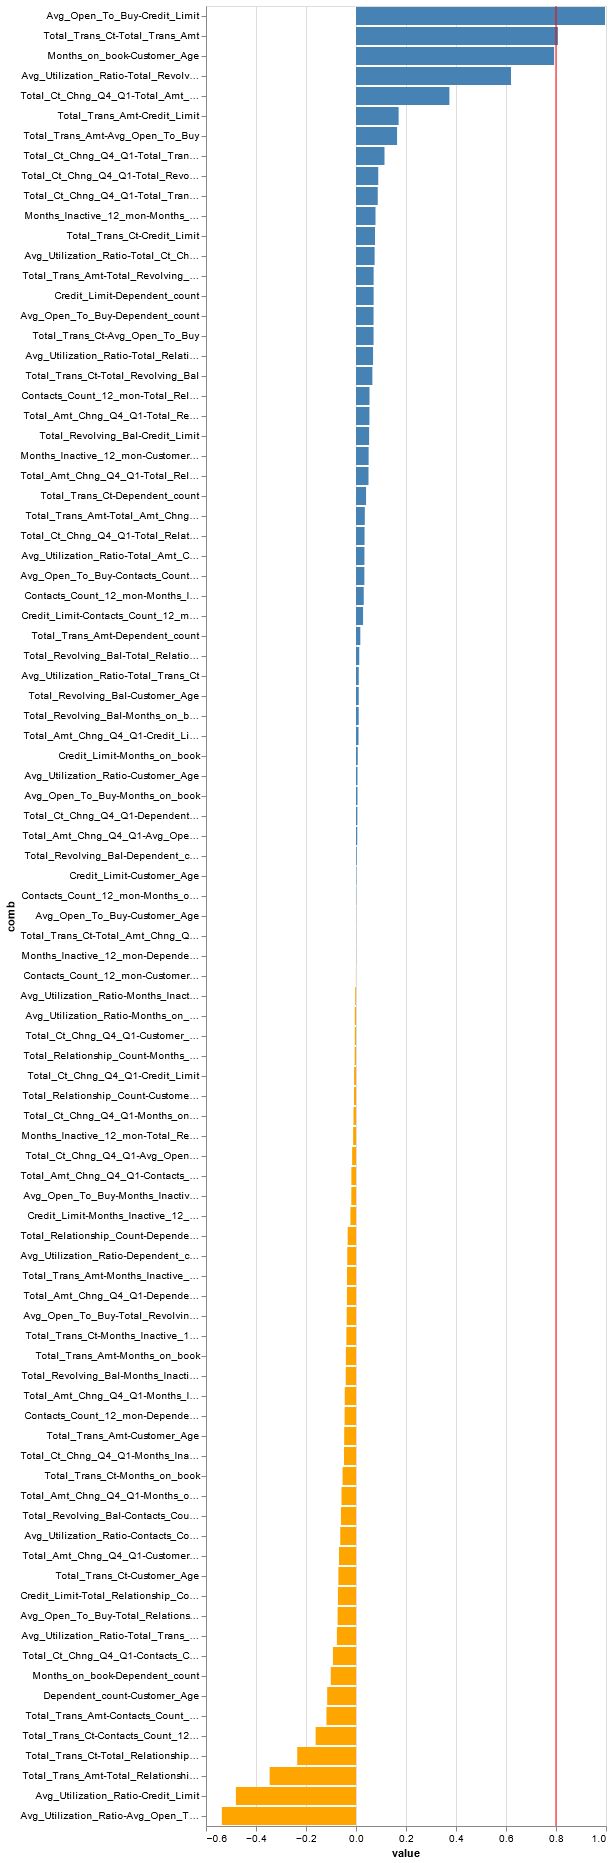

In [18]:
plot_corr(cc_churn_tr)

# Conclusões

Pela análise descritiva, os fatores mais importantes para a existência de atrito tem a ver com padrões de utilização do cartão. Consumidores em atrito tendem a gastar menos o cartão como proporção do limite e gastam menos e em menor frequência durante o ano.

Essa análise preliminar pode sugerir que o incentivo a utilização do cartão pode ser uma boa maneira para garantir fidelidade. Exemplos podem incluir criar um programa de milha, cashback ou algum outro tipo de benefício.

# Encaminhamentos para Pré-Processamento dos Dados

- `Gender` e `Marital_Status`: OneHotEncoder
- `Card_Type`: OneHotEncoder e agregar infrequentes como "outros"
- `Education_Level` e `Income_Category`: OrdinalEncoder
- `Avg_Open_To_Buy` e `Credit_Limit`: tem correlação praticamente perfeita. Manterei somente `Credit_Limit`
- `Credit_Limit`, `Total_Revolving_Bal`, `Total_Trans_Amt`, `Avg_Utilization_Ratio`: Logs
- Restante das variáveis numéricas: Padronizar